## **importing the required libraries and loding the data**

In [24]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

link = "./winequality-red.csv"
data = pd.read_csv(link, sep=';')

# operations to remove the duplicate data rowr

In [ ]:
print(data.shape)
duplicate_data = data[data.duplicated()]
print("Number of duplicate rows:", duplicate_data.shape)
# removing the duplicates
data = data.drop_duplicates()

print("Number of rows After dropping Duplicate:", data.shape)

(1359, 12)
Number of duplicate rows: (0, 12)
Number of rows After dropping Duplicate: (1359, 12)


# IQR method for Outliers

In [ ]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

fixed acidity            2.10000
volatile acidity         0.25000
citric acid              0.34000
residual sugar           0.70000
chlorides                0.02100
free sulfur dioxide     14.00000
total sulfur dioxide    41.00000
density                  0.00222
pH                       0.19000
sulphates                0.18000
alcohol                  1.60000
quality                  1.00000
dtype: float64


# **Vizualization of Outliers**

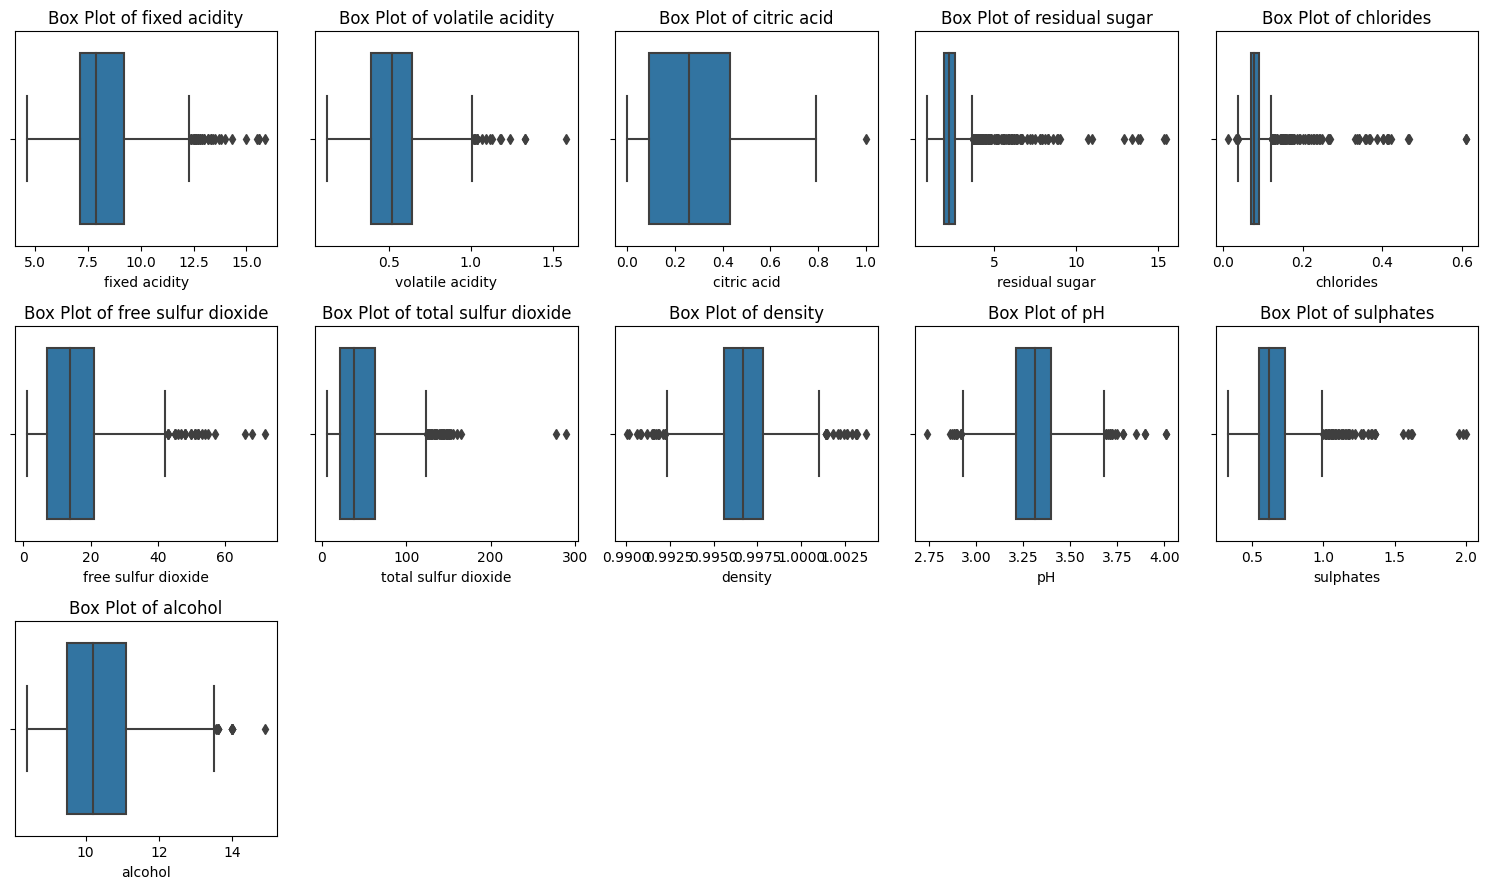

In [ ]:
 #Calculating  the number of columns and rows for subplots
num_cols = len(data.columns[:-1])
num_rows = (num_cols - 1) // 5 + 1

# Create a figure with subplots for box plots
fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(15, num_rows * 3))
axes = axes.flatten()

# Box plots for each feature
for i, col in enumerate(data.columns[:-1]):
    sns.boxplot(x=data[col], ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}')
    axes[i].set_ylabel('')

# Remove any empty subplots
for i in range(num_cols, num_rows * 5):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Removing outliers and Reseting the data

In [ ]:
# creating a copy of data to overcome the SettingWithCopyWarning error
data_no_outliers = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)].copy()

# Create an ordinal classification problem:
data_no_outliers['quality_ordinal'] = np.where(data_no_outliers['quality'] <= 4, 0, np.where(data_no_outliers['quality'] <= 6, 1, 2))


# Vizualizing the data in the form of histogram after removing outliers

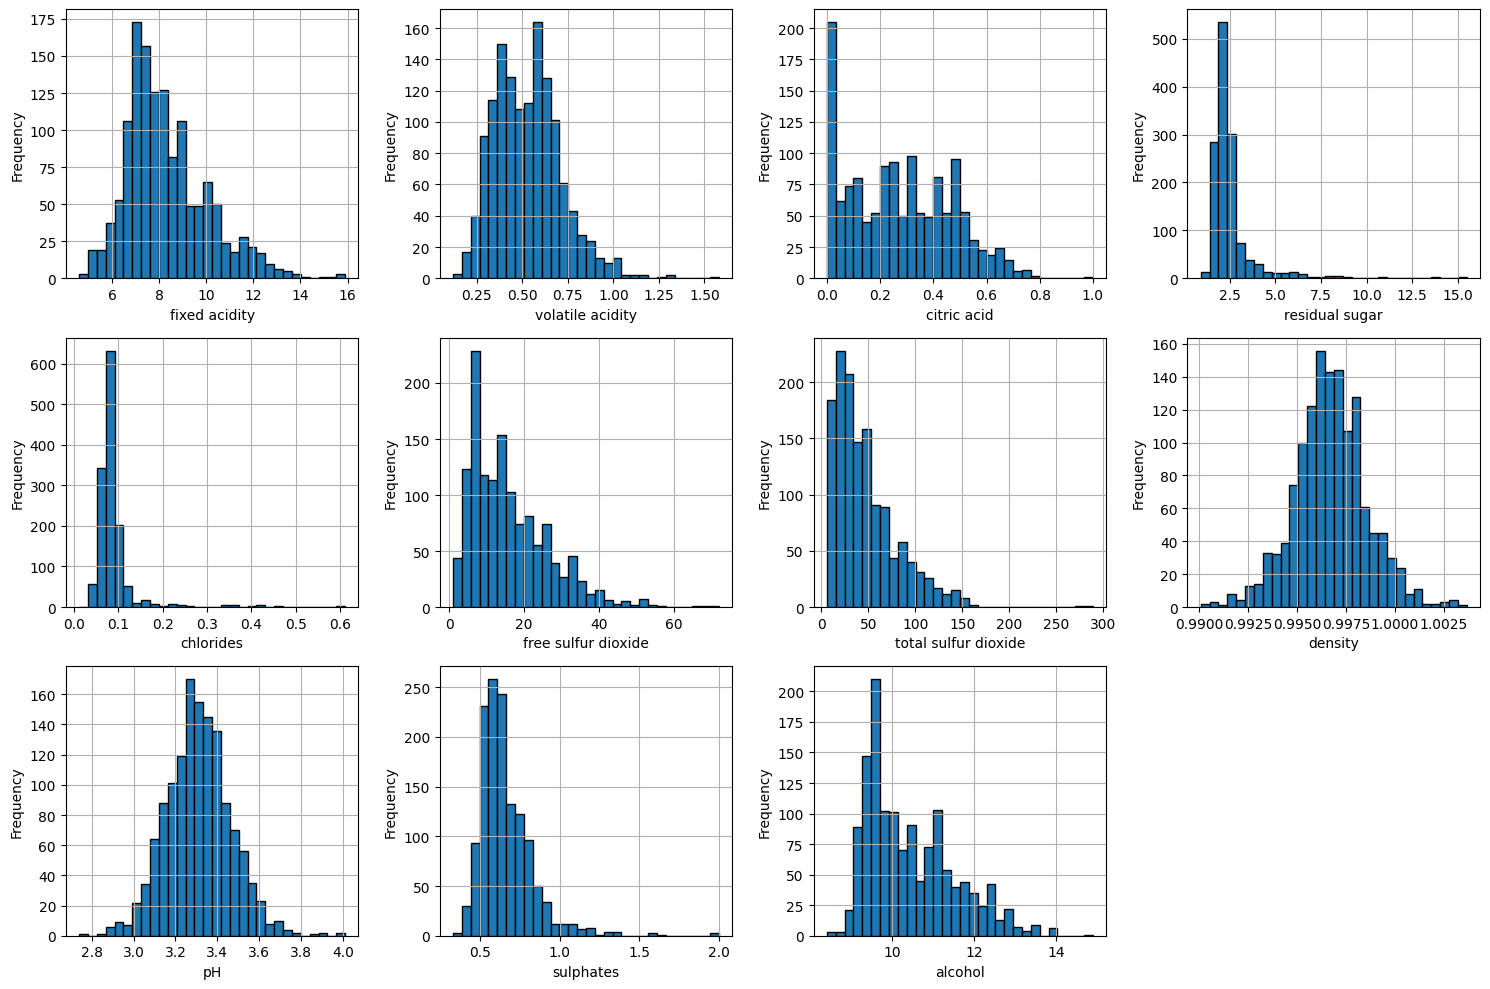

In [ ]:
# vizualizing the data after removing the outliers using histogram  for each feature

plt.figure(figsize=(15, 10))
for i, col in enumerate(data.columns[:-1]):
    plt.subplot(3, 4, i+1)
    data[col].hist(bins=30, edgecolor='k')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Heat Map

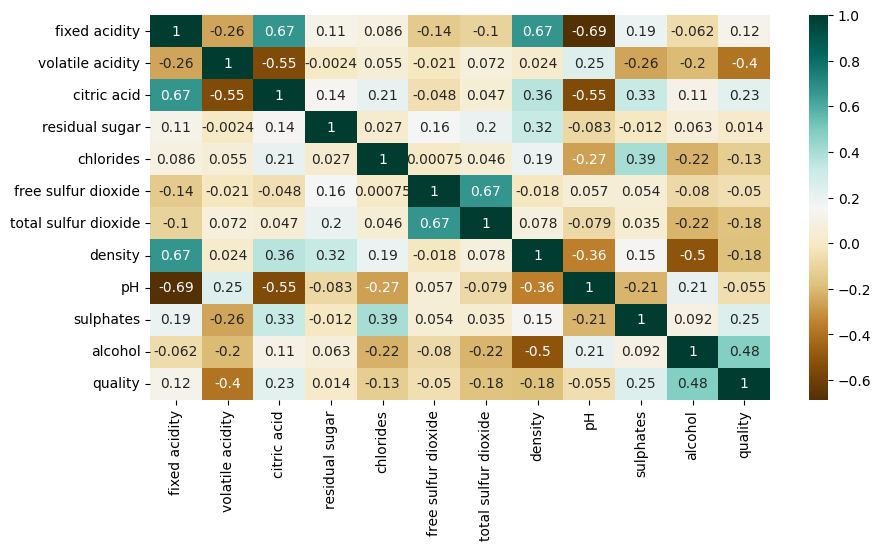

In [ ]:
plt.figure(figsize=(10, 5))
c = data.corr()
sns.heatmap(c, cmap="BrBG", annot=True)

X = data_no_outliers.drop(['quality', 'quality_ordinal'], axis=1)
y = data_no_outliers['quality_ordinal']

# Spliting the data in 80%training and 20%test and Vizualizing

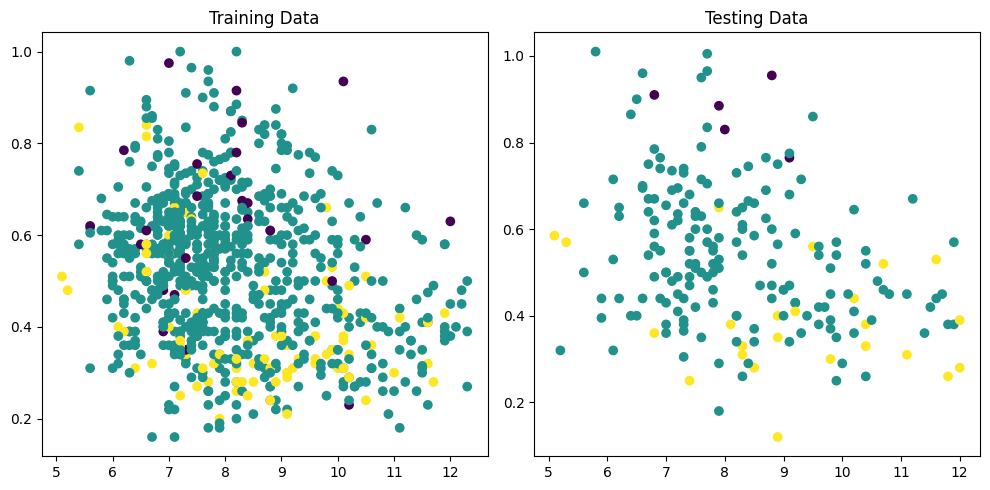

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vizualization of splited data
plt.figure(figsize=(10, 5))

# Plot training data
plt.subplot(1, 2, 1)
plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, cmap='viridis')

plt.title("Training Data")

# Plot testing data
plt.subplot(1, 2, 2)
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 1], c=y_test, cmap='viridis')

plt.title("Testing Data")

plt.tight_layout()
plt.show()


# Ordinal Regression Model

In [ ]:
#  ordinal regression model using statsmodels
X_train_const = sm.add_constant(X_train)  # Add a constant term
ord_model = sm.OLS(y_train, X_train_const).fit()

# predictions on the test set
X_test_const = sm.add_constant(X_test)
ord_predictions = ord_model.predict(X_test_const).round().astype(int)

# Evaluate the ordinal regression model using mean adsolut error
ord_mae = mean_absolute_error(y_test, ord_predictions)
print("Ordinal Regression MAE:", ord_mae)

Ordinal Regression MAE: 0.12935323383084577


# Linear Rigression Model

In [ ]:
#linear regression model to compare
lin_model = LinearRegression()
lin_model.fit(X_train, data_no_outliers.loc[y_train.index, 'quality'])

# predictions using linear regression
lin_predictions = lin_model.predict(X_test)

# Evaluate the linear regression model using mean adsolut error
lin_mae = mean_absolute_error(data_no_outliers.loc[y_test.index, 'quality'], lin_predictions)
print("Linear Regression MAE:", lin_mae)

Linear Regression MAE: 0.46383070297451745


# Residual Plotting of both MOdels

# The Residual plots clearly show how better the Ordinal Regression model than Linear regression

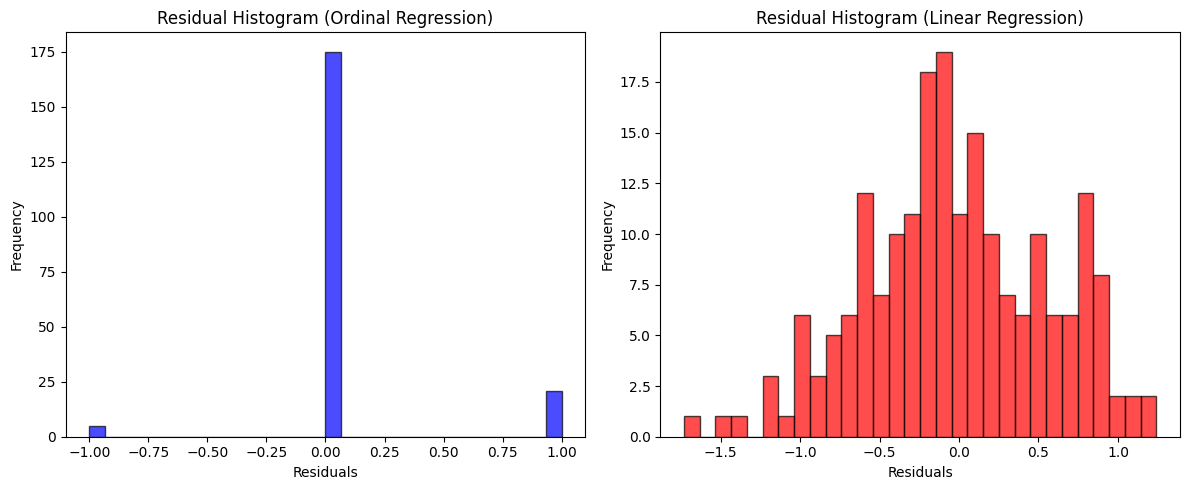

In [ ]:
# Residual ploting of both the model to show the fitting of data in model using histograms
#  ordinal regression
ord_residuals = y_test - ord_predictions

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(ord_residuals, bins=30, edgecolor='k', color='blue', alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Histogram (Ordinal Regression)")

# linear regression
lin_residuals = data_no_outliers.loc[y_test.index, 'quality'] - lin_predictions

plt.subplot(1, 2, 2)
plt.hist(lin_residuals, bins=30, edgecolor='k', color='red', alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Histogram (Linear Regression)")

plt.tight_layout()
plt.show()

# PLotting the Result

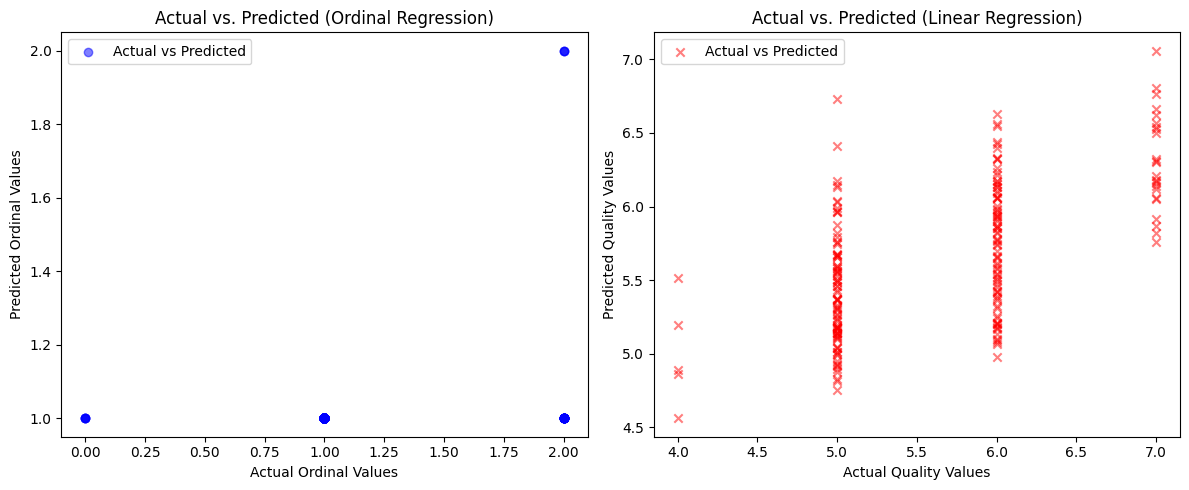

In [ ]:

# Plotting the results
plt.figure(figsize=(12, 5))

# Plot actual vs. predicted values for ordinal regression
plt.subplot(1, 2, 1)
plt.scatter(y_test, ord_predictions, alpha=0.5, c='blue', marker='o', label='Actual vs Predicted')
plt.xlabel("Actual Ordinal Values")
plt.ylabel("Predicted Ordinal Values")
plt.title("Actual vs. Predicted (Ordinal Regression)")
plt.legend()

# Plot actual vs. predicted values for linear regression
plt.subplot(1, 2, 2)
plt.scatter(data_no_outliers.loc[y_test.index, 'quality'], lin_predictions, alpha=0.5, c='red', marker='x', label='Actual vs Predicted')
plt.xlabel("Actual Quality Values")
plt.ylabel("Predicted Quality Values")
plt.title("Actual vs. Predicted (Linear Regression)")
plt.legend()

plt.tight_layout()
plt.show()

# Final Comparision of model

In [ ]:
# Comparing the results of two models
if ord_mae < lin_mae:
    print("Ordinal Regression performs better.")
else:
    print("Linear Regression performs better.")

Ordinal Regression performs better.
